In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import VarianceThreshold
%matplotlib inline

In [2]:
def print_nulls(df):
    
    out = df.isnull().sum()*100/df.isnull().isnull().count()
    
    pd.set_option('display.max_rows', len(out))
    print(out)
    pd.reset_option('display.max_rows')

In [24]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [3]:
raw_data = pd.read_csv('https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/epi_r.csv')

In [4]:
raw_data.shape

(20052, 680)

In [5]:
raw_data.head()
raw_data.tail()

,title,rating,calories,protein,fat,sodium,#cakeweek,#wasteless,22-minute meals,3-ingredient recipes,...,yellow squash,yogurt,yonkers,yuca,zucchini,cookbooks,leftovers,snack,snack week,turkey
20047,Parmesan Puffs,3.125,28.0,2.0,2.0,64.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20048,Artichoke and Parmesan Risotto,4.375,671.0,22.0,28.0,583.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20049,Turkey Cream Puff Pie,4.375,563.0,31.0,38.0,652.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
20050,Snapper on Angel Hair with Citrus Cream,4.375,631.0,45.0,24.0,517.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20051,Baked Ham with Marmalade-Horseradish Glaze,4.375,560.0,73.0,10.0,3698.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
raw_data['rating'].unique()

array([2.5  , 4.375, 3.75 , 5.   , 3.125, 1.875, 0.   , 1.25 ])

In [7]:
# Create a binary classifier
raw_data.loc[raw_data['rating'] < 3, 'rating'] = 0
raw_data.loc[raw_data['rating'] > 3, 'rating'] = 1


In [8]:
raw_data['rating'].unique()

array([0., 1.])

In [9]:
null_count = raw_data.isnull().sum()
null_count[null_count>0]

calories    4117
protein     4162
fat         4183
sodium      4119
dtype: int64

In [10]:
raw_data.drop(['calories', 'protein', 'fat', 'sodium'], axis=1, inplace=True)

In [11]:
# It may be worth considering keywords in the title but for now just drop it
raw_data.drop('title', axis=1, inplace=True)

In [12]:
# A lot of these keywords appear very rarely. 
mask = VarianceThreshold(.05).fit(raw_data).get_support()
raw_data.loc[:, mask].columns

Index(['rating', 'appetizer', 'bake', 'bon appétit', 'cheese', 'chicken',
       'chill', 'cocktail party', 'dairy', 'dairy free', 'dessert', 'dinner',
       'drink', 'egg', 'fall', 'fruit', 'garlic', 'ginger', 'gourmet',
       'grill/barbecue', 'healthy', 'herb', 'kid-friendly', 'kidney friendly',
       'kosher', 'lemon', 'lunch', 'milk/cream', 'no sugar added', 'no-cook',
       'onion', 'peanut free', 'pescatarian', 'potato', 'quick & easy',
       'roast', 'salad', 'sauce', 'sauté', 'side', 'soup/stew', 'soy free',
       'spring', 'sugar conscious', 'summer', 'thanksgiving', 'tomato',
       'tree nut free', 'vegan', 'vegetable', 'vegetarian',
       'wheat/gluten-free', 'winter'],
      dtype='object')

In [13]:
mask = VarianceThreshold(.01).fit(raw_data).get_support()
raw_data.loc[:, mask].columns

Index(['rating', 'alcoholic', 'almond', 'appetizer', 'apple', 'apricot',
       'arugula', 'asparagus', 'avocado', 'backyard bbq',
       ...
       'vegetable', 'vegetarian', 'vinegar', 'walnut', 'wheat/gluten-free',
       'white wine', 'winter', 'yogurt', 'zucchini', 'turkey'],
      dtype='object', length=205)

In [14]:
# Only roughly 1/3 or keywords appear in at least 1 percent of our data. 
# This seems like a good threshold to begin with
mask = VarianceThreshold(.01).fit(raw_data).get_support()
raw_data = raw_data.loc[:, mask]


X = raw_data.drop('rating', axis=1)
y = raw_data['rating']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=1312)

In [19]:
cross_val_score(classifier, X_train, y_train, cv=5)

array([0.87267287, 0.87200798, 0.87599734, 0.87034574, 0.87229797])

In [20]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score, classification_report
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score

In [30]:
classifier = SVC(kernel = 'linear', probability=True)

classifier.fit(X_train, y_train)

predictions = classifier.predict(X_test)
confusion = confusion_matrix(y_test, predictions)

In [23]:
confusion

array([[  38,  628],
       [  13, 4334]])

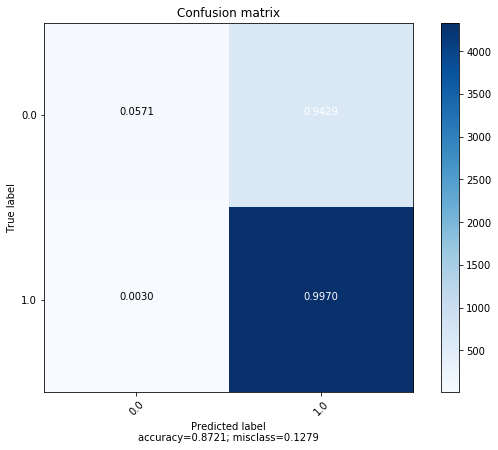

In [31]:
plot_confusion_matrix(confusion, y.unique())

In [32]:
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average=None)
recall = recall_score(y_test, predictions, average=None)
f1 = f1_score(y_test, predictions, average=None)
fbeta_precision = fbeta_score(y_test, predictions, 0.5, average=None)
fbeta_recall = fbeta_score(y_test, predictions, 2, average=None)

print('Accuracy score: {}'.format(accuracy))
print('Precision score: {}'.format(precision.mean()))
print('Recall score: {}'.format(recall.mean()))
print('F1 score: {}'.format(f1.mean()))
print('Fbeta score favoring precision: {}'.format(fbeta_precision.mean()))
print('FBeta score favoring recall: {}'.format(fbeta_recall.mean()))

Accuracy score: 0.8721324556154
Precision score: 0.8092680845010314
Recall score: 0.5270332444245488
F1 score: 0.5185695581411969
Fbeta score favoring precision: 0.5570151997776686
FBeta score favoring recall: 0.5197782639326634


In [33]:
probabilities = classifier.predict_proba(X_test)[:, 1]

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, probabilities)

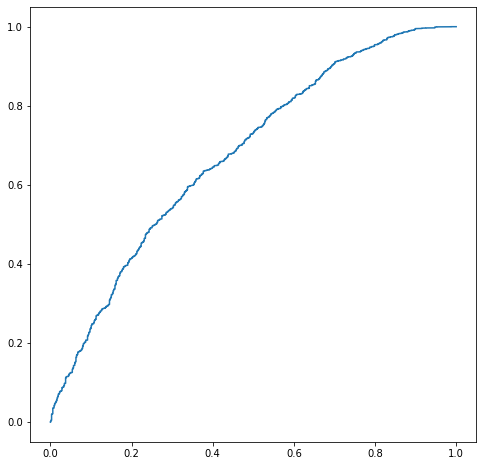

In [34]:
plt.figure(figsize=(8,8))
plt.plot(false_positive_rate, true_positive_rate)

In [35]:
roc_auc_score(y_test, predictions)

0.5270332444245488

Performance is significantly better than the orginal model. However there is lots of room for improvement. Could the ratings be binned more effectively than just a binary? This is still including features with a variance of only 1%, can we narrow that down farther to something like 5 percent? What about different a different kernel or more aggressive regularization? There are many options that could improve the performance of this model. Most should focus on reducing noise from the features.